In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mindstorm import statplot
from tesser import tasks

main_dir = os.environ['TESSER_DIR']
data_dir = os.path.join(main_dir, 'Data')
fig_dir = os.path.join(main_dir, 'Figures', 'plots')

In [2]:
parse = tasks.load_parse(data_dir)
parse.head(25)

,subject,run,block,trial,trial_type,path_type,community,transition,prev_walk,object,object_type,response,response_time
0,100,1,1,1,random,random,1,False,0,21,central,0,NaN
1,100,1,1,2,random,random,1,False,0,3,boundary,0,NaN
2,100,1,1,3,random,random,1,False,0,20,central,1,0.818487
3,100,1,1,4,random,random,1,False,0,3,boundary,0,NaN
4,100,1,1,5,random,random,1,False,0,2,central,1,0.914617
5,100,1,1,6,random,random,1,False,0,3,boundary,1,0.769570
6,100,1,1,7,random,random,2,True,6,4,boundary,0,NaN
7,100,1,1,8,random,random,2,False,6,8,central,1,0.949561
8,100,1,1,9,random,random,2,False,6,10,boundary,0,NaN
9,100,1,1,10,random,random,2,False,6,8,central,0,NaN


In [3]:
trans_parse = (
    parse.query('transition and prev_walk >= 4')
    .groupby(['subject', 'trial_type'])['response']
    .mean()
)
other_parse = (
    parse.query('~(transition and prev_walk >= 4)')
    .groupby(['subject', 'trial_type'])['response']
    .mean()
)
results = pd.concat([trans_parse, other_parse], keys=['transition', 'other'])
results.index.set_names('parse_type', level=0, inplace=True)

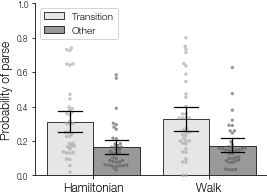

In [4]:
fig, ax = plt.subplots(figsize=(4, 3))
light = [(.9, .9, .9), (.6, .6, .6)]
dark = [(.7, .7, .7), (.4, .4, .4)]
statplot.plot_swarm_bar(
    results.reset_index(),
    x='trial_type',
    y='response',
    hue='parse_type',
    dodge=True,
    light=light,
    dark=dark,
    bar_kws={'capsize': .2},
    ax=ax,
)
ax.set(xticklabels=['Hamiltonian', 'Walk'], ylabel='Probability of parse', ylim=[0, 1])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Transition', 'Other']);
fig.savefig(os.path.join(fig_dir, 'parsing_transition.pdf'))

In [5]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.7.6
IPython version      : 7.11.1

matplotlib: 3.1.3
tesser    : 0.1.0
seaborn   : 0.11.1
pandas    : 1.0.1
numpy     : 1.18.1
mindstorm : 0.7.0

